In [44]:
import json
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
from sklearn.datasets import make_circles

# Circles Example

In [46]:
data, target = make_circles(n_samples=500, noise=.05, factor=.5)

In [47]:
color = [["red", "blue"][elem] for elem in target]

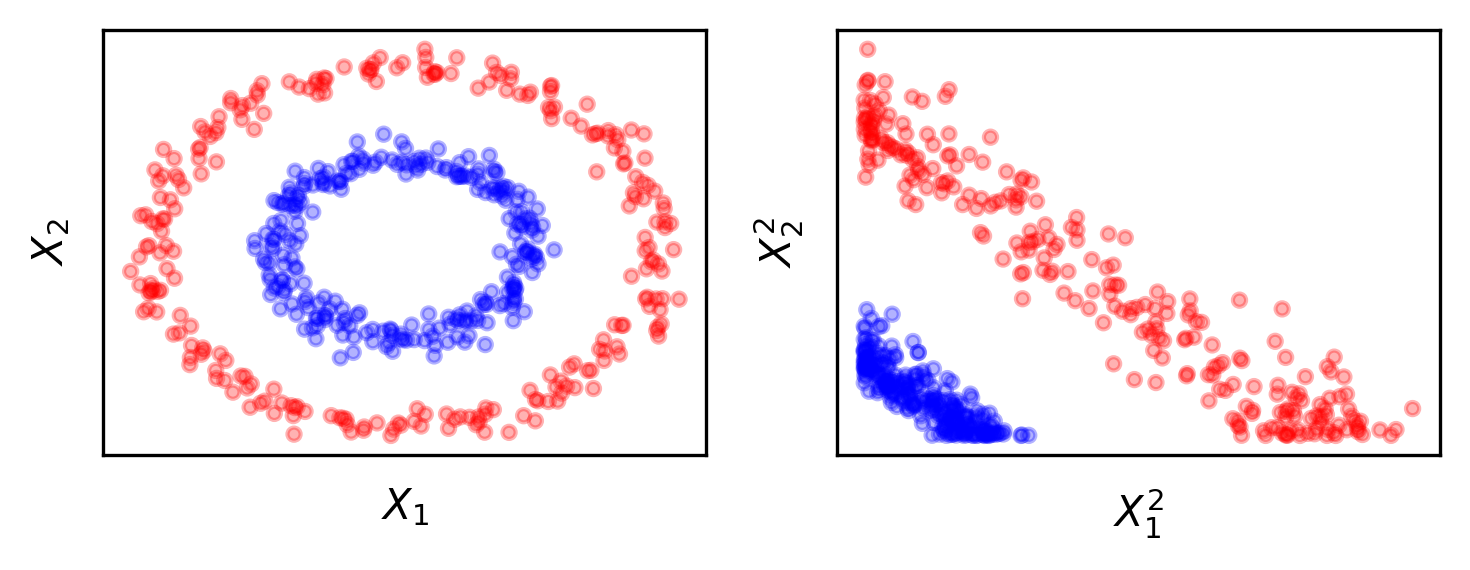

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2), dpi=300)
ax[0].scatter(data[:, 0], data[:, 1], color=color, alpha=.3, s=10)
ax[1].scatter(data[:, 0]**2, data[:, 1]**2, color=color, alpha=.3, s=10)

ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[0].set_xlabel("$X_1$")
ax[0].set_ylabel("$X_2$")

ax[1].set_xlabel("$X_1^2$")
ax[1].set_ylabel("$X_2^2$")

plt.tight_layout()
plt.savefig("circles.pdf")

# Default Metrics

In [49]:
from src.datasets import alldts
from src.metrics import cluster_evaluate

In [50]:
selection = {"cred_aus", "cred_ger", "breast_coimbra", "sonar", "heart"}
datasets = [(k, v) for k, v in alldts().items() if k in selection]

In [51]:
aux = list()
for dataset_name, (data, target) in datasets:
    aux.append(dict({"dataset": dataset_name}, **cluster_evaluate(data.values, target.values)))

In [52]:
pd.DataFrame(aux)

,dataset,gg_neigh_index,gg_neigh_count,silhouette_score,sil_neg_samples_score,calinski_harabasz_score,davies_bouldin_score
0,cred_aus,0.392134,0.221739,0.053858,0.262319,27.747245,4.544958
1,cred_ger,0.416974,0.300000,0.012343,0.273000,8.946278,9.466610
2,breast_coimbra,0.398623,0.250000,0.023419,0.413793,5.092652,4.223749
3,sonar,0.452967,0.370192,0.035338,0.326923,8.906266,4.595280
4,heart,0.383518,0.211111,0.101432,0.162963,29.881538,2.852883


# Results

In [53]:
files = glob("results/*.json")

aux = list()
for file in files:
    with open(file, "r") as f:
        aux.append(json.load(f))
df = pd.json_normalize(aux)

In [54]:
df["acc_diff"] = (df["acc_test"] - df["acc_train"]).abs()

In [55]:
colors = {
    "cred_ger": "red",
    "cred_aus": "blue",
    "breast_coimbra": "green",
    "heart": "black",
    "sonar": "purple",
}

In [56]:
import matplotlib.patches as mpatches

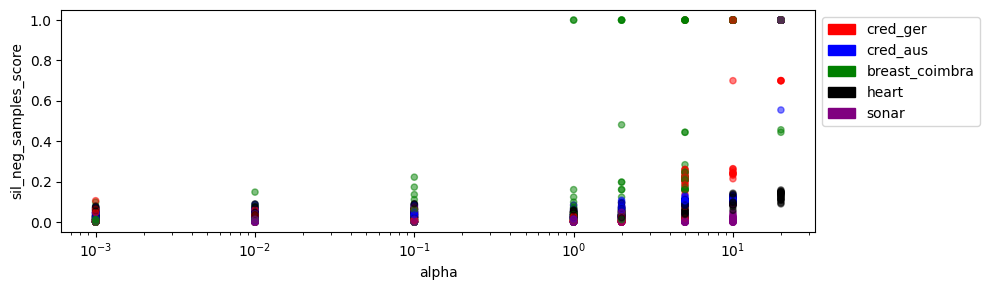

In [75]:
plt.figure(figsize=(10, 3), dpi=100)
ax = plt.gca()
df.plot.scatter(
    x="alpha", y="sil_neg_samples_score",
    c=df["dataset"].apply(lambda x: colors[x]),
    alpha=.5, ax=ax
)
plt.xscale("log")

plt.legend(
    handles=[mpatches.Patch(color=v, label=k) for k, v in colors.items()],
    bbox_to_anchor=(1, 1)
)
plt.tight_layout()
plt.savefig("silneg.pdf")

In [ ]:
metrics = [
    "silhouette_score", "sil_neg_samples_score",
    "calinski_harabasz_score", "davies_bouldin_score",
    "gg_neigh_index", "gg_neigh_count",
]

In [68]:
df.corr(numeric_only=True)[["acc_diff", "acc_train", "acc_test", "alpha"]].loc[metrics]

,acc_diff,acc_train,acc_test,alpha
silhouette_score,0.778692,0.964283,0.658035,-0.839680
sil_neg_samples_score,-0.682584,-0.954982,-0.738149,0.788159
calinski_harabasz_score,0.021655,0.064269,0.073227,-0.062453
davies_bouldin_score,-0.309355,-0.158986,0.068613,0.188197
gg_neigh_index,-0.768395,-0.983188,-0.695592,0.805854
gg_neigh_count,-0.711282,-0.989145,-0.759163,0.792528


In [69]:
aux = list()
for name, group in df.groupby("dataset"):
    group["acc_diff"] = group["acc_test"] - group["acc_train"]
    for metric in metrics:
        aux.append({
            "dataset": name,
            "metric": metric,
            "coefs": {
                "acc_test": np.poly1d(np.polyfit(group["acc_test"], group[metric], 1)).coef[0],
                "acc_diff": np.poly1d(np.polyfit(group["acc_diff"], group[metric], 1)).coef[0],
                "alpha": np.poly1d(np.polyfit(group["alpha"], group[metric], 1)).coef[0],
                "best_loss": np.poly1d(np.polyfit(group["best_loss"], group[metric], 1)).coef[0],
            }
        })

In [70]:
(
    pd.json_normalize(aux)
    .pivot(
        index="metric", columns="dataset",
        values=[
            "coefs.acc_test",
            "coefs.acc_diff",
            "coefs.alpha",
            "coefs.best_loss",
        ]
    )
)

coefs.acc_test                             \
dataset                 breast_coimbra     cred_aus      cred_ger   
metric                                                              
calinski_harabasz_score   6.176457e+07 -2085.377402  2.055370e+09   
davies_bouldin_score     -7.883230e-02     0.609692  2.410895e+00   
gg_neigh_count           -1.511100e+00    -1.314034 -1.787935e+00   
gg_neigh_index           -1.585168e+00    -1.312481 -2.212321e+00   
sil_neg_samples_score    -3.371573e+00    -3.096376 -6.687007e+00   
silhouette_score          3.181230e+00     2.605017  5.351770e+00   

                                                   coefs.acc_diff  \
dataset                        heart         sonar breast_coimbra   
metric                                                              
calinski_harabasz_score -5401.216902  2.200990e+10  -9.134843e+07   
davies_bouldin_score        0.485603  7.867846e-02   4.530032e-01   
gg_neigh_count             -0.779783 -1.340333e+00   1.362198e+00   
gg_neigh_index             -0.720580 -1.405608e+00   1.488033e+00   
sil_neg_samples_score      -1.919353 -2.872180e+00   3.008961e+00   
silhouette_score            1.402968  2.768708e+00  -3.024806e+00   

                                                                    \
dataset                       cred_aus      cred_ger         heart   
metric                                                               
calinski_harabasz_score -124333.033678 -3.082727e+08 -9.815169e+06   
davies_bouldin_score          1.368845  1.547376e+00  2.169368e+00   
gg_neigh_count                1.705306  9.196278e-01  6.762270e-01   
gg_neigh_index                2.022025  1.369051e+00  9.917852e-01   
sil_neg_samples_score         3.696697  2.814510e+00  1.249846e+00   
silhouette_score             -4.234166 -3.293483e+00 -2.275897e+00   

                                         coefs.alpha              \
dataset                         sonar breast_coimbra    cred_aus   
metric                                                             
calinski_harabasz_score  1.923722e+09  -1.236877e+06 -446.845284   
davies_bouldin_score    -1.146576e-01   3.500198e-03    0.002815   
gg_neigh_count           1.565769e+00   2.417982e-02    0.018921   
gg_neigh_index           1.634161e+00   2.552910e-02    0.020573   
sil_neg_samples_score    3.355685e+00   5.439167e-02    0.043337   
silhouette_score        -3.215578e+00  -5.203111e-02   -0.043328   

                                                                   \
dataset                      cred_ger         heart         sonar   
metric                                                              
calinski_harabasz_score -5.524609e+06 -61638.660662 -3.248778e+08   
davies_bouldin_score     1.028218e-02      0.023752  3.116871e-03   
gg_neigh_count           1.585413e-02      0.007366  2.070459e-02   
gg_neigh_index           2.223785e-02      0.010382  2.177011e-02   
sil_neg_samples_score    5.197083e-02      0.014287  4.417451e-02   
silhouette_score        -5.406366e-02     -0.026411 -4.559854e-02   

                        coefs.best_loss                              \
dataset                  breast_coimbra      cred_aus      cred_ger   
metric                                                                
calinski_harabasz_score   -5.118588e+07 -26680.265767 -2.643878e+08   
davies_bouldin_score       5.177875e-01      0.409591  8.744848e-01   
gg_neigh_count             5.441997e-01      0.437576  4.037861e-01   
gg_neigh_index             6.362568e-01      0.522451  6.170073e-01   
sil_neg_samples_score      1.150195e+00      0.962288  1.197539e+00   
silhouette_score          -1.338674e+00     -1.149474 -1.510901e+00   

                                                     
dataset                         heart         sonar  
metric                                               
calinski_harabasz_score -3.057494e+06 -1.137440e+10  
davies_bouldin_score     7.501060e-01  1.974090e-01  
gg_n

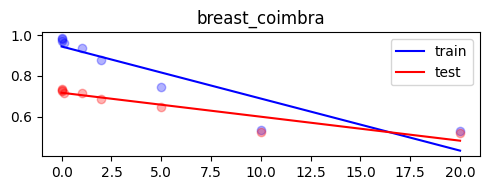

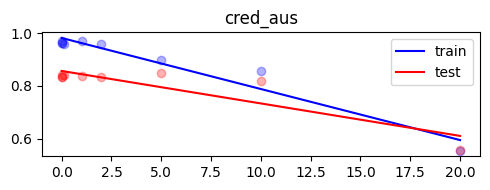

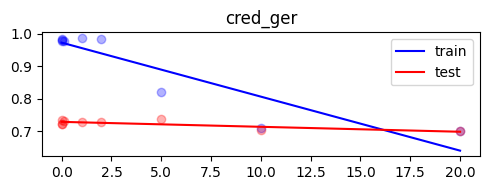

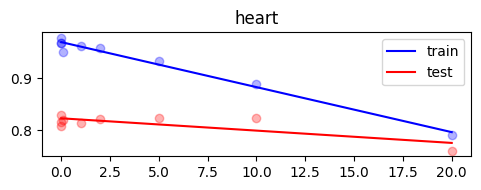

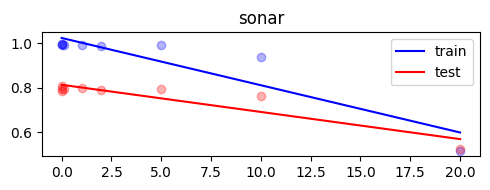

In [71]:
for name, group in df.groupby(["dataset", "alpha"], as_index=False).mean().groupby("dataset"):
    x = group["alpha"]
    poly_train = np.poly1d(np.polyfit(group["alpha"], group["acc_train"], 1))
    poly_test = np.poly1d(np.polyfit(group["alpha"], group["acc_test"], 1))

    plt.figure(figsize=(5, 2))
    ax = plt.gca()
    plt.plot(x, poly_train(x), label="train", color="blue")
    plt.plot(x, poly_test(x), label="test", color="red")
    plt.scatter(x, group["acc_train"], color="blue", alpha=.3)
    plt.scatter(x, group["acc_test"], color="red", alpha=.3)
    plt.legend()
    plt.title(name)
    plt.tight_layout()
    plt.show()
    plt.close()

---